# Synthetic financial time series data generation

## Team members: 
- **Tao Manxi**(ID: 2230026145)
- **Xia Yixin**(ID: 2230026171)

In [1]:
# Synthetic Financial Time Series Generation with LSTM-GAN
import torch
import torch.nn as nn
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import time
from tqdm import tqdm

# Configuration Parameters
TICKER = '^NDX'
TRAIN_START_DATE = '2011-01-01'
TRAIN_END_DATE = '2021-12-31'
SEQUENCE_LENGTH = 100  # Approximately 1 trading year
LEARNING_RATE = 0.0001
EPOCHS = 2000
BATCH_SIZE = 64
NOISE_DIMENSION = 50
HIDDEN_DIMENSION = 256
NUM_GENERATED_SAMPLES = 1000

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using computing device: {device}")

Using computing device: cuda


In [2]:
# Data Acquisition and Preprocessing
# Download historical data from Yahoo Finance
raw_data = yf.download(TICKER, start=TRAIN_START_DATE, end=TRAIN_END_DATE)

# Calculate logarithmic returns (financial time series standard)
log_returns = np.log(raw_data['Close'] / raw_data['Close'].shift(1)).dropna().values.reshape(-1, 1)

# Normalize data to [-1, 1] range for stable training
scaler = MinMaxScaler(feature_range=(-1, 1))
normalized_returns = scaler.fit_transform(log_returns)

# Create sequential data samples
sequences = []
for i in range(len(normalized_returns) - SEQUENCE_LENGTH):
    sequences.append(normalized_returns[i:i+SEQUENCE_LENGTH])

# Convert to PyTorch tensors and move to device
real_sequences = torch.FloatTensor(np.array(sequences)).to(device)

# Create data loader for batch processing
dataset = TensorDataset(real_sequences)
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

C:\Users\Cecilia\AppData\Local\Temp\ipykernel_54748\942804606.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw_data = yf.download(TICKER, start=TRAIN_START_DATE, end=TRAIN_END_DATE)
[*********************100%***********************]  1 of 1 completed


In [3]:
# # Load data from CSV file
# data = pd.read_csv('data/RESSET_GDQTTN_1.csv')

# # Ensure date column is parsed correctly and sorted
# data['TrdDt'] = pd.to_datetime(data['TrdDt'])
# data = data.sort_values('TrdDt')

# # Calculate log returns using ClPr column (consistent with original financial time series processing)
# log_returns = np.log(data['ClPr'] / data['ClPr'].shift(1)).dropna().values.reshape(-1, 1)

# scaler = MinMaxScaler(feature_range=(-1, 1))
# normalized_returns = scaler.fit_transform(log_returns)

# # Create sequential data samples
# sequences = []
# for i in range(len(normalized_returns) - SEQUENCE_LENGTH):
#     sequences.append(normalized_returns[i:i+SEQUENCE_LENGTH])

# # Convert to PyTorch tensor and move to device
# real_sequences = torch.FloatTensor(np.array(sequences)).to(device)

# # Create data loader
# dataset = TensorDataset(real_sequences)
# data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [4]:
# LSTM-GAN Architecture Definition
class LSTMGenerator(nn.Module):
    """Generator network using LSTM to produce synthetic time series"""
    def __init__(self, noise_dim, hidden_dim, output_dim=1):
        super(LSTMGenerator, self).__init__()
        self.lstm = nn.LSTM(input_size=noise_dim, 
                           hidden_size=hidden_dim, 
                           num_layers=1, 
                           batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_output, _ = self.lstm(x)
        generated_output = self.fc(lstm_output)
        return torch.tanh(generated_output)  # Match normalization range [-1,1]


class LSTMDiscriminator(nn.Module):
    """Discriminator network using LSTM to distinguish real/fake sequences"""
    def __init__(self, input_dim=1, hidden_dim=128):
        super(LSTMDiscriminator, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, 
                           hidden_size=hidden_dim, 
                           num_layers=1, 
                           batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        _, (hidden_state, _) = self.lstm(x)  # Use final hidden state for classification
        discriminator_output = self.fc(hidden_state.squeeze(0))
        return torch.sigmoid(discriminator_output)  # Probability output [0,1]

In [5]:
# Model Initialization and Training Setup
# Initialize networks
generator = LSTMGenerator(noise_dim=NOISE_DIMENSION, hidden_dim=HIDDEN_DIMENSION).to(device)
discriminator = LSTMDiscriminator(hidden_dim=HIDDEN_DIMENSION).to(device)

# Loss function and optimizers
criterion = nn.BCELoss()  # Binary cross-entropy for binary classification
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=LEARNING_RATE)
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=LEARNING_RATE)

D_losses = []
G_losses = []

# Training loop with progress tracking
print("\nStarting LSTM-GAN training process...")
start_time = time.time()

# Training with progress bar
for epoch in tqdm(range(EPOCHS), desc="Training Progress", unit="epoch"):
    total_d_loss = 0.0
    total_g_loss = 0.0
    batch_count = 0
    
    for batch in data_loader:
        real_sequences_batch = batch[0]
        batch_size = real_sequences_batch.size(0)
        
        # Labels for real (1) and fake (0) data
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Train Discriminator on real data
        optimizer_discriminator.zero_grad()
        real_output = discriminator(real_sequences_batch)
        loss_real = criterion(real_output, real_labels)
        
        # Train Discriminator on fake data
        noise = torch.randn(batch_size, SEQUENCE_LENGTH, NOISE_DIMENSION).to(device)
        fake_sequences = generator(noise)
        fake_output = discriminator(fake_sequences.detach())  # Detach to prevent generator update
        loss_fake = criterion(fake_output, fake_labels)
        
        # Total discriminator loss and optimization step
        discriminator_loss = (loss_real + loss_fake)
        discriminator_loss.backward()
        optimizer_discriminator.step()

        # Train Generator
        optimizer_generator.zero_grad()
        fake_output = discriminator(fake_sequences)  # No detach - need gradients for generator
        generator_loss = criterion(fake_output, real_labels)  # Fool discriminator into thinking fake is real
        generator_loss.backward()
        optimizer_generator.step()

        D_losses.append(discriminator_loss.item())
        G_losses.append(generator_loss.item())
        
        # Total loss
        total_d_loss += discriminator_loss.item()
        total_g_loss += generator_loss.item()
        batch_count += 1
        
    if epoch % 100 == 0:
        avg_d_loss = total_d_loss / batch_count
        avg_g_loss = total_g_loss / batch_count
        print(f"[Epoch {epoch}/{EPOCHS}] [D loss: {avg_d_loss:.4f}] [G loss: {avg_g_loss:.4f}]")
    
# Calculate and display total training time
end_time = time.time()
training_duration = end_time - start_time
print(f"\nTraining completed. Total time: {training_duration:.2f} seconds ({training_duration/60:.2f} minutes)")

# Generate synthetic samples after training
generator.eval()  # Set to evaluation mode
with torch.no_grad():
    noise = torch.randn(NUM_GENERATED_SAMPLES, SEQUENCE_LENGTH, NOISE_DIMENSION).to(device)
    generated_normalized = generator(noise).cpu().numpy()

# Inverse transform to original scale
generated_returns = scaler.inverse_transform(generated_normalized.reshape(-1, SEQUENCE_LENGTH))
real_returns_flat = scaler.inverse_transform(real_sequences.cpu().numpy().reshape(-1, SEQUENCE_LENGTH)).flatten()
generated_returns_flat = generated_returns.flatten()

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')


Starting LSTM-GAN training process...


Training Progress:   0%|                                                         | 1/2000 [00:04<2:16:03,  4.08s/epoch]

[Epoch 0/2000] [D loss: 1.3866] [G loss: 0.6894]


Training Progress:   5%|██▊                                                    | 101/2000 [05:30<1:41:10,  3.20s/epoch]

[Epoch 100/2000] [D loss: 1.3865] [G loss: 0.7257]


Training Progress:  10%|█████▌                                                 | 201/2000 [11:07<1:45:33,  3.52s/epoch]

[Epoch 200/2000] [D loss: 1.3843] [G loss: 0.6930]


Training Progress:  15%|████████▎                                              | 301/2000 [17:27<1:57:26,  4.15s/epoch]

[Epoch 300/2000] [D loss: 1.3859] [G loss: 0.6934]


Training Progress:  20%|███████████                                            | 401/2000 [23:50<1:44:05,  3.91s/epoch]

[Epoch 400/2000] [D loss: 1.3861] [G loss: 0.6926]


Training Progress:  25%|█████████████▊                                         | 501/2000 [30:18<1:37:49,  3.92s/epoch]

[Epoch 500/2000] [D loss: 1.3823] [G loss: 0.6914]


Training Progress:  30%|████████████████▌                                      | 601/2000 [36:47<1:29:32,  3.84s/epoch]

[Epoch 600/2000] [D loss: 1.3864] [G loss: 0.6931]


Training Progress:  35%|███████████████████▎                                   | 701/2000 [43:12<1:23:31,  3.86s/epoch]

[Epoch 700/2000] [D loss: 1.3912] [G loss: 0.6573]


Training Progress:  40%|██████████████████████                                 | 801/2000 [49:39<1:18:07,  3.91s/epoch]

[Epoch 800/2000] [D loss: 1.3884] [G loss: 0.6571]


Training Progress:  45%|████████████████████████▊                              | 901/2000 [56:08<1:10:50,  3.87s/epoch]

[Epoch 900/2000] [D loss: 1.3817] [G loss: 0.6915]


Training Progress:  50%|██████████████████████████                          | 1001/2000 [1:02:35<1:05:20,  3.92s/epoch]

[Epoch 1000/2000] [D loss: 1.3796] [G loss: 0.6910]


Training Progress:  55%|█████████████████████████████▋                        | 1101/2000 [1:09:02<57:31,  3.84s/epoch]

[Epoch 1100/2000] [D loss: 1.3864] [G loss: 0.6746]


Training Progress:  60%|████████████████████████████████▍                     | 1201/2000 [1:15:31<50:00,  3.76s/epoch]

[Epoch 1200/2000] [D loss: 1.3859] [G loss: 0.6927]


Training Progress:  65%|███████████████████████████████████▏                  | 1301/2000 [1:22:02<45:10,  3.88s/epoch]

[Epoch 1300/2000] [D loss: 1.3856] [G loss: 0.7539]


Training Progress:  70%|█████████████████████████████████████▊                | 1401/2000 [1:28:24<38:12,  3.83s/epoch]

[Epoch 1400/2000] [D loss: 1.3877] [G loss: 0.6931]


Training Progress:  75%|████████████████████████████████████████▌             | 1501/2000 [1:34:47<32:16,  3.88s/epoch]

[Epoch 1500/2000] [D loss: 1.3852] [G loss: 0.6875]


Training Progress:  80%|███████████████████████████████████████████▏          | 1601/2000 [1:41:12<25:44,  3.87s/epoch]

[Epoch 1600/2000] [D loss: 1.3877] [G loss: 0.6881]


Training Progress:  85%|█████████████████████████████████████████████▉        | 1701/2000 [1:47:38<19:17,  3.87s/epoch]

[Epoch 1700/2000] [D loss: 1.3842] [G loss: 0.7018]


Training Progress:  90%|████████████████████████████████████████████████▋     | 1801/2000 [1:54:01<12:12,  3.68s/epoch]

[Epoch 1800/2000] [D loss: 1.3847] [G loss: 0.6988]


Training Progress:  95%|███████████████████████████████████████████████████▎  | 1901/2000 [2:00:25<06:23,  3.87s/epoch]

[Epoch 1900/2000] [D loss: 1.3963] [G loss: 0.6142]


Training Progress: 100%|██████████████████████████████████████████████████████| 2000/2000 [2:06:47<00:00,  3.80s/epoch]


Training completed. Total time: 7607.57 seconds (126.79 minutes)


Plotting: Time Series Comparison


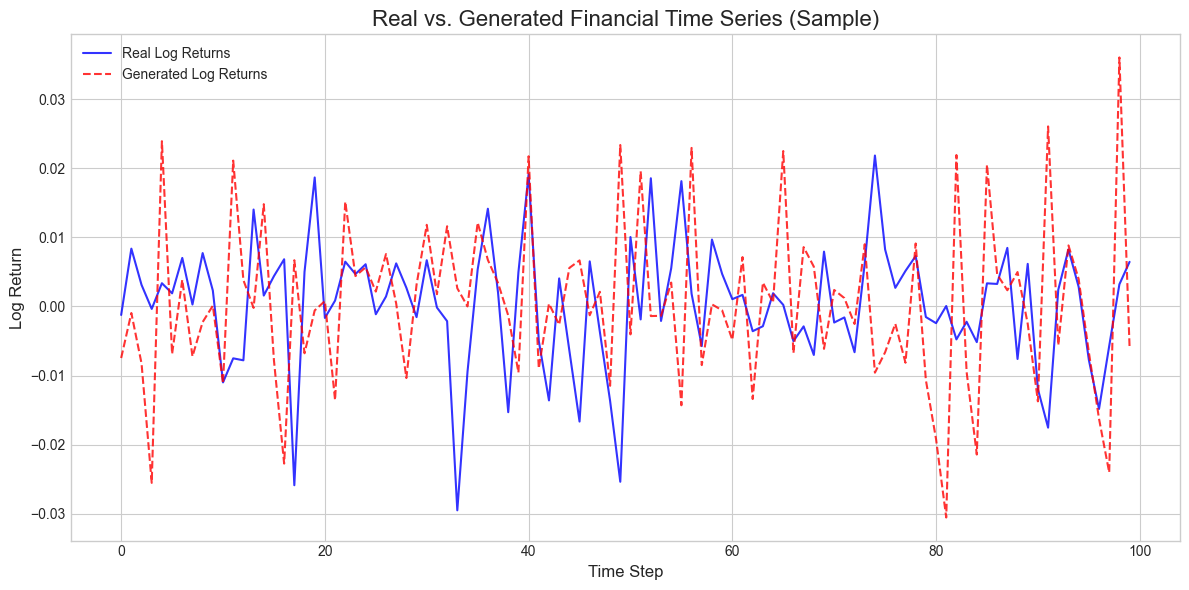

In [6]:
# Plot 1: Time Series Comparison
print("Plotting: Time Series Comparison")
plt.figure(figsize=(12, 6))
plt.plot(real_returns_flat[:SEQUENCE_LENGTH], label='Real Log Returns', color='blue', alpha=0.8)
plt.plot(generated_returns_flat[:SEQUENCE_LENGTH], label='Generated Log Returns', color='red', linestyle='--', alpha=0.8)
plt.title('Real vs. Generated Financial Time Series (Sample)', fontsize=16)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Log Return', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

Plotting: Empirical PDF (KDE)


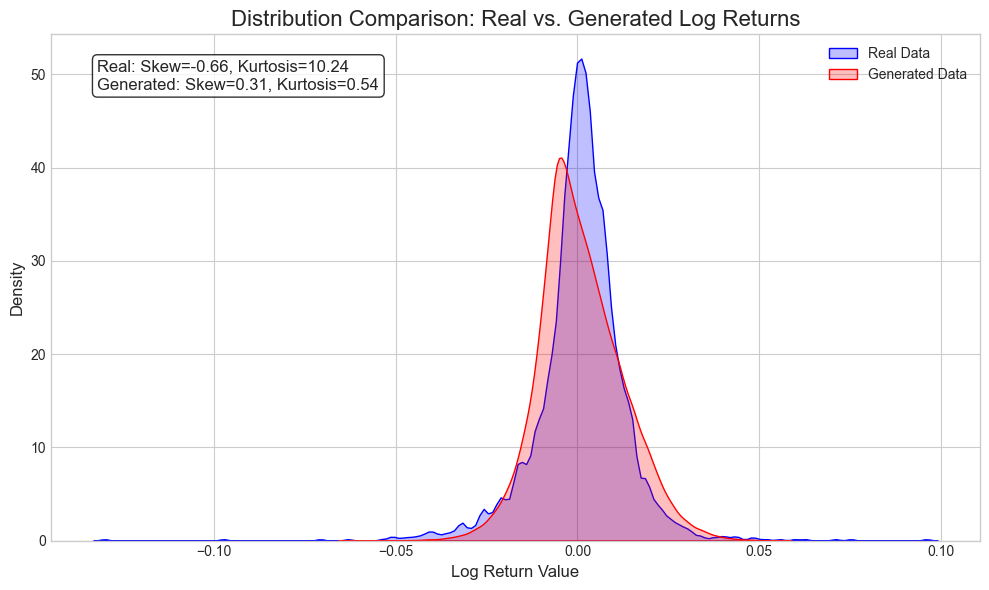

In [7]:
# Plot 2: Empirical Probability Density Function (KDE)
print("Plotting: Empirical PDF (KDE)")
plt.figure(figsize=(10, 6))
sns.kdeplot(real_returns_flat, label='Real Data', color='blue', fill=True)
sns.kdeplot(generated_returns_flat, label='Generated Data', color='red', fill=True)

# Calculate and display statistical moments
real_skewness = skew(real_returns_flat)
real_kurtosis = kurtosis(real_returns_flat)
gen_skewness = skew(generated_returns_flat)
gen_kurtosis = kurtosis(generated_returns_flat)

plt.text(0.05, 0.95, 
         f'Real: Skew={real_skewness:.2f}, Kurtosis={real_kurtosis:.2f}\nGenerated: Skew={gen_skewness:.2f}, Kurtosis={gen_kurtosis:.2f}',
         transform=plt.gca().transAxes, fontsize=12, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.title('Distribution Comparison: Real vs. Generated Log Returns', fontsize=16)
plt.xlabel('Log Return Value', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

Plotting: Autocorrelation Function (ACF) of Squared Returns


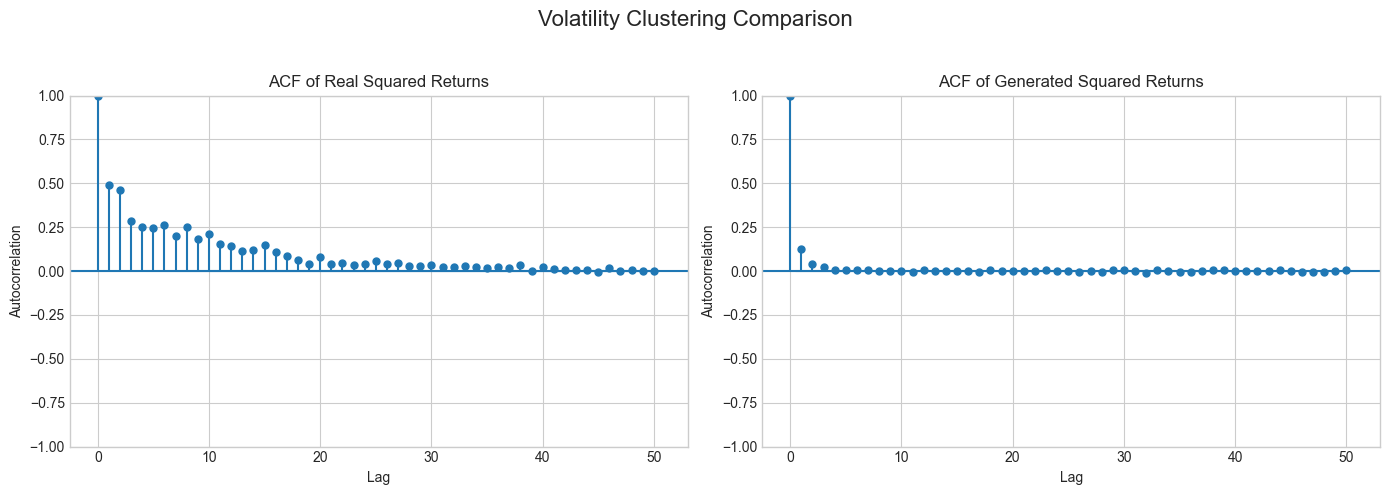

In [8]:
# Plot 3: Autocorrelation Function (ACF) of Squared Returns
print("Plotting: Autocorrelation Function (ACF) of Squared Returns")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ACF for real squared returns (measures volatility clustering)
plot_acf(real_returns_flat**2, lags=50, ax=axes[0], title='ACF of Real Squared Returns')
axes[0].set_xlabel('Lag', fontsize=10)
axes[0].set_ylabel('Autocorrelation', fontsize=10)

# ACF for generated squared returns
plot_acf(generated_returns_flat**2, lags=50, ax=axes[1], title='ACF of Generated Squared Returns')
axes[1].set_xlabel('Lag', fontsize=10)
axes[1].set_ylabel('Autocorrelation', fontsize=10)

plt.suptitle('Volatility Clustering Comparison', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to prevent title overlap
plt.show()

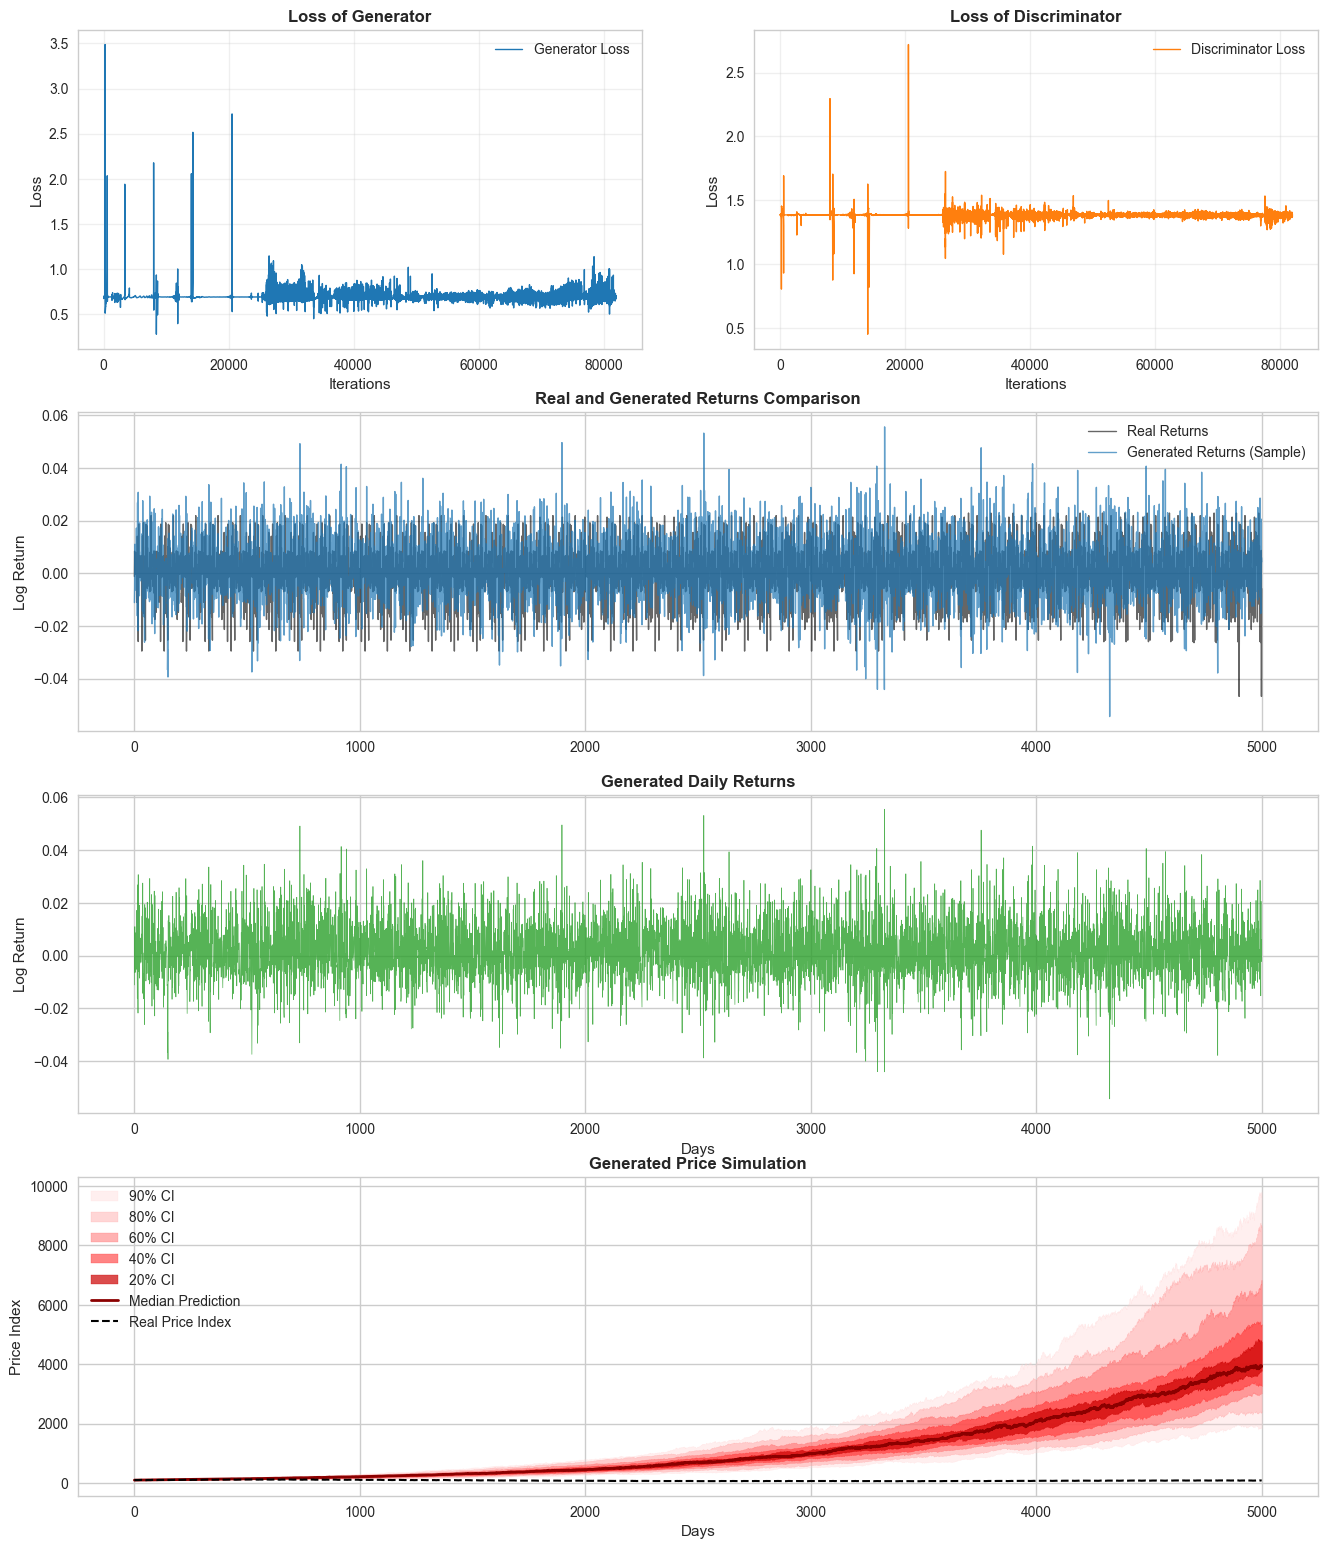

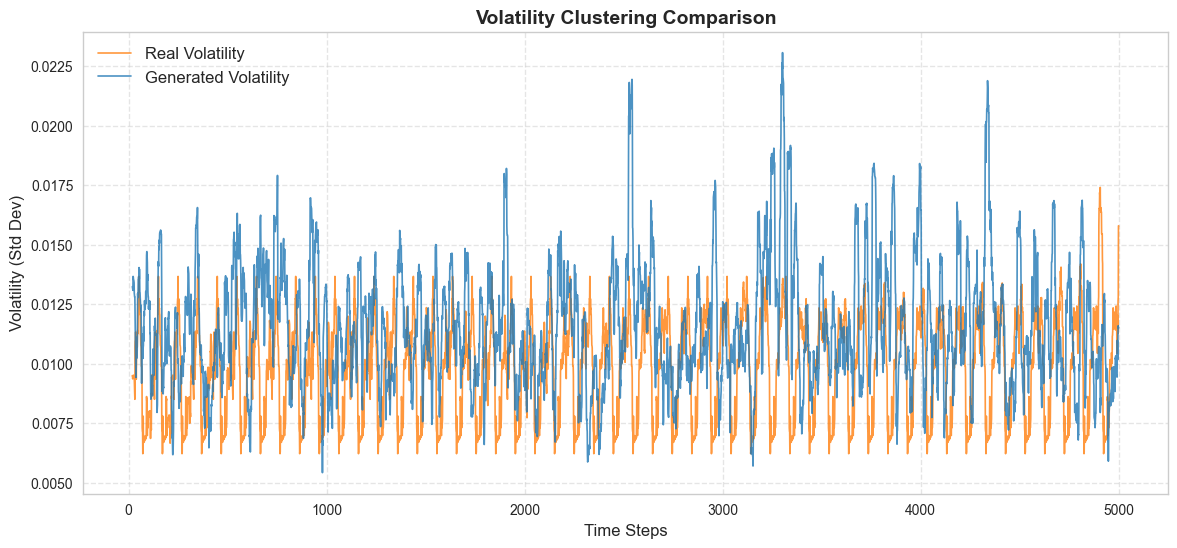

In [9]:
# 7. Evaluation and visualization
generator.eval()
with torch.no_grad():
    # z = torch.randn(2000, NOISE_DIMENSION, SEQUENCE_LENGTH).to(device)
    z = torch.randn(2000, SEQUENCE_LENGTH, NOISE_DIMENSION).to(device) 
    generated_data = generator(z).cpu().numpy().squeeze()

    generated_returns = scaler.inverse_transform(generated_data.reshape(-1, 1)).flatten()
    real_returns = scaler.inverse_transform(real_sequences.cpu().numpy().reshape(-1, 1)).flatten()

plt.style.use('seaborn-v0_8')

S0 = 100

def returns_to_index(returns, start_price):
    cumulative_returns = np.cumsum(returns)
    cumulative_returns = np.clip(cumulative_returns, -10, 10)
    index = start_price * np.exp(cumulative_returns)
    return np.insert(index, 0, start_price)

real_data_tensor = real_sequences.cpu().numpy()
real_returns_flat = scaler.inverse_transform(real_data_tensor.reshape(-1, 1)).flatten()
real_len = min(len(real_returns_flat), 5000)
real_returns_arr = real_returns_flat[:real_len]
real_price_arr = returns_to_index(real_returns_arr, S0)

n_simulations = 100
simulated_price_paths = []
simulated_returns_paths = []

netG = generator
device = device 
latent_dim = NOISE_DIMENSION
seq_len = SEQUENCE_LENGTH 
gen_seq_len = 5000 

if netG:
    netG.eval()
    with torch.no_grad():
        for _ in range(n_simulations):
            z = torch.randn(1, gen_seq_len, latent_dim).to(device) 
            
            fake_data = netG(z).cpu().numpy().squeeze()
            
            fake_ret = scaler.inverse_transform(fake_data.reshape(-1, 1)).flatten()
            
            simulated_returns_paths.append(fake_ret)
            simulated_price_paths.append(returns_to_index(fake_ret, S0))

    simulated_price_paths = np.array(simulated_price_paths)
    simulated_returns_paths = np.array(simulated_returns_paths)

    percentiles = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95]
    fan_data = np.percentile(simulated_price_paths, percentiles, axis=0)
    median_path = fan_data[5]  # 中位数路径
else:
    median_path = np.zeros(2000)
    fan_data = np.zeros((11, 2000))
    simulated_returns_paths = [np.random.randn(2000)*0.01]

plt.style.use('seaborn-v0_8-whitegrid')
fig = plt.figure(figsize=(16, 24)) 

try:
    ax1 = plt.subplot(5, 2, 1)
    plt.plot(G_losses, label='Generator Loss', color='#1f77b4', linewidth=1)
    plt.title("Loss of Generator", fontsize=12, fontweight='bold')
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)

    ax2 = plt.subplot(5, 2, 2)
    plt.plot(D_losses, label='Discriminator Loss', color='#ff7f0e', linewidth=1)
    plt.title("Loss of Discriminator", fontsize=12, fontweight='bold')
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
except:
    print("Please add the code for loss recording during the training process.")

ax3 = plt.subplot(5, 1, 2)
zoom_len = 5000
plt.plot(real_returns_arr[:zoom_len], label='Real Returns', color='black', alpha=0.6, linewidth=1)
plt.plot(simulated_returns_paths[0][:zoom_len], label='Generated Returns (Sample)', color='#1f77b4', alpha=0.7, linewidth=1)
plt.title("Real and Generated Returns Comparison", fontsize=12, fontweight='bold')
plt.ylabel("Log Return")
plt.legend()

ax4 = plt.subplot(5, 1, 3)
plt.plot(simulated_returns_paths[0], color='#2ca02c', alpha=0.8, linewidth=0.5)
plt.title("Generated Daily Returns", fontsize=12, fontweight='bold')
plt.xlabel("Days")
plt.ylabel("Log Return")

# Fan Chart
ax5 = plt.subplot(5, 1, 4)
x_axis = range(len(median_path))

plt.fill_between(x_axis, fan_data[0], fan_data[10], color='#ffcccc', alpha=0.3, label='90% CI')
plt.fill_between(x_axis, fan_data[1], fan_data[9],  color='#ff9999', alpha=0.4, label='80% CI')
plt.fill_between(x_axis, fan_data[2], fan_data[8],  color='#ff6666', alpha=0.5, label='60% CI')
plt.fill_between(x_axis, fan_data[3], fan_data[7],  color='#ff3333', alpha=0.6, label='40% CI')
plt.fill_between(x_axis, fan_data[4], fan_data[6],  color='#cc0000', alpha=0.7, label='20% CI')

plt.plot(x_axis, median_path, color='darkred', linewidth=2, label='Median Prediction')

real_price_len = min(len(real_price_arr), len(x_axis))
plt.plot(x_axis[:real_price_len], real_price_arr[:real_price_len], color='black', linewidth=1.5, linestyle='--', label='Real Price Index')

plt.title("Generated Price Simulation", fontsize=12, fontweight='bold')
plt.xlabel("Days")
plt.ylabel("Price Index")
plt.legend(loc='upper left')

WINDOW_SIZE = 20  
volatility_real = pd.Series(real_returns_arr).rolling(window=WINDOW_SIZE).std()
volatility_fake = pd.Series(simulated_returns_paths[0]).rolling(window=WINDOW_SIZE).std()

plt.figure(figsize=(14, 6))
plt.plot(volatility_real, label='Real Volatility', color='#ff7f0e', alpha=0.8, linewidth=1.2)
plt.plot(volatility_fake, label='Generated Volatility', color='#1f77b4', alpha=0.8, linewidth=1.2)
plt.title(f'Volatility Clustering Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Volatility (Std Dev)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, which='major', linestyle='--', alpha=0.5)
plt.show()

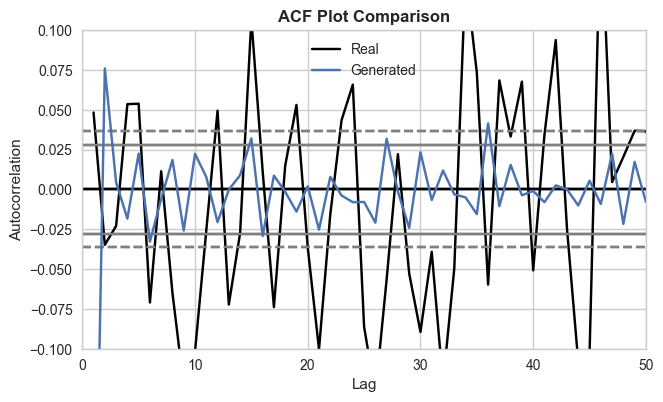

In [10]:
plt.style.use('seaborn-v0_8-whitegrid')
fig = plt.figure(figsize=(16, 24)) 
ax6 = plt.subplot(5, 2, 9)
s_real = pd.Series(real_returns_arr)
s_fake = pd.Series(simulated_returns_paths[0])

pd.plotting.autocorrelation_plot(s_real, label='Real', color='black', ax=ax6)
pd.plotting.autocorrelation_plot(s_fake, label='Generated', ax=ax6)

ax6.set_title("ACF Plot Comparison", fontsize=12, fontweight='bold')
ax6.set_xlim([0, 50])  # 调整滞后范围，使其更易读
ax6.set_ylim([-0.1, 0.1]) 
ax6.legend()

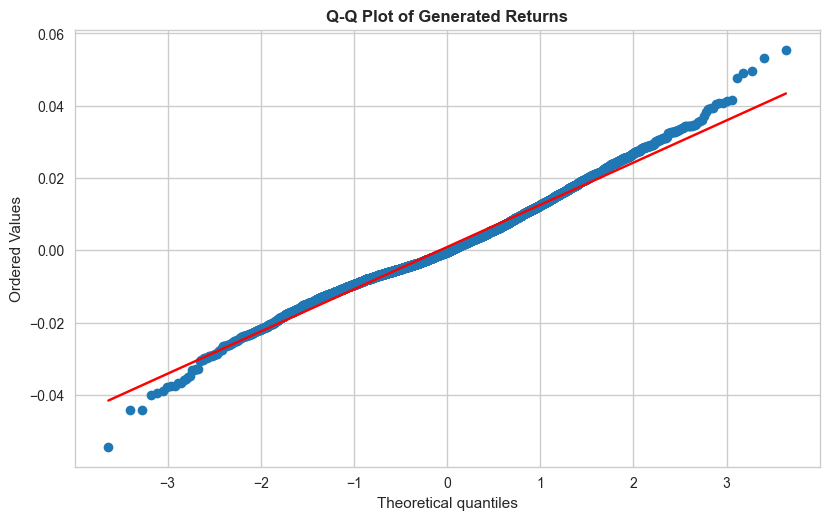

In [11]:
# Q-Q plot
import scipy.stats as stats
plt.style.use('seaborn-v0_8-whitegrid')
fig = plt.figure(figsize=(16, 24)) 
ax7 = plt.subplot(5, 2, 10)
stats.probplot(simulated_returns_paths[0], dist="norm", plot=ax7)
ax7.get_lines()[0].set_markerfacecolor('#1f77b4') 
ax7.get_lines()[1].set_color('red') 
ax7.set_title("Q-Q Plot of Generated Returns", fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

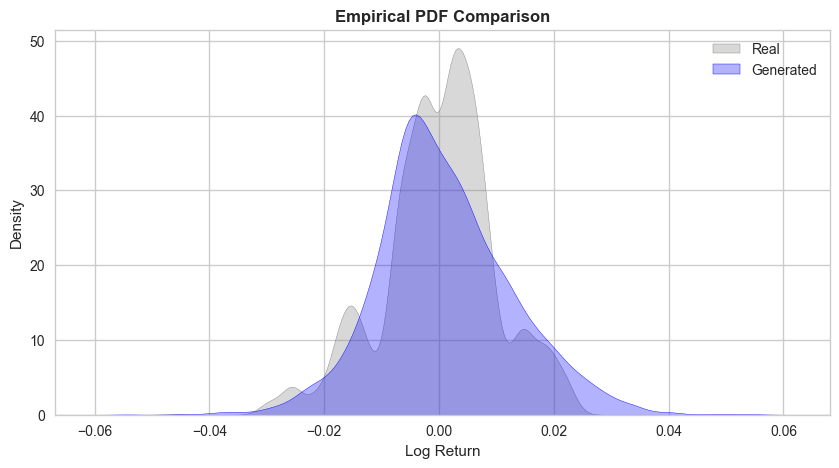

       Real Returns  Generated Returns
count   5000.000000      500000.000000
mean      -0.000041           0.000750
std        0.009920           0.011669
min       -0.046726          -0.068797
25%       -0.005165          -0.006804
50%        0.001057          -0.000501
75%        0.006170           0.007990
max        0.022843           0.056081


In [12]:
plt.figure(figsize=(10, 5))
sns.kdeplot(real_returns_arr, label='Real', fill=True, color='grey', alpha=0.3)
sns.kdeplot(simulated_returns_paths[0], label='Generated', fill=True, color='blue', alpha=0.3)
plt.title("Empirical PDF Comparison", fontsize=12, fontweight='bold')
plt.xlabel("Log Return")
plt.legend()
plt.show()

quantgan_returns = simulated_returns_paths.reshape(-1) 

quantgan_series = pd.Series(quantgan_returns, name="Generated Returns")
real_series = pd.Series(real_returns_arr, name="Real Returns")

stats_table = pd.concat([real_series.describe(), quantgan_series.describe()], axis=1)
print(stats_table)